In [39]:
import os
import io
import zipfile
from sqlalchemy import engine_from_config
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from hornstone.alchemy import Base
import us
from revaers.models import Data, VaxData
from revaers.parser import parse_csv
from revaers.parser import parse_csvfile
from revaers.parser import parse_vaxfile

import numpy as np
import plotly.io as pio
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf

plt.style.use('dark_background')



In [40]:

dburl = 'postgresql+psycopg2://dbadmin@localhost/revaers'
settings = {'sqlalchemy.url': dburl}
engine = engine_from_config(settings)
Base.metadata.create_all(engine)
Session = sessionmaker()
Session.configure(bind=engine)


In [41]:
s = Session()


In [42]:
s.query(Data).count()


75517

In [43]:

def make_data_frame(query):
    return pd.read_sql(query.statement, query.session.bind)


In [44]:

query = s.query(Data, VaxData).join(VaxData)
query = query.filter(VaxData.vax_type == 'COVID19').filter(Data.died == True)
#query = query.filter(Data.state == 'MS')

df = make_data_frame(query)


In [45]:
df

,vaers_id,recvdate,state,age_yrs,cage_yr,cage_mo,sex,rpt_date,symptom_text,died,...,bad_dates,questionable,vaers_id,vax_type,vax_manu,vax_lot,vax_dose_series,vax_route,vax_site,vax_name
0,917117,2021-01-01,AR,82.0,82.0,,M,None,"After vaccination, patient tested positive for...",True,...,False,False,917117,COVID19,MODERNA,,1,IM,AR,COVID19 (COVID19 (MODERNA))
1,917790,2021-01-03,AR,90.0,90.0,,F,None,"At the time of vaccination, there was an outbr...",True,...,False,False,917790,COVID19,MODERNA,,1,IM,AR,COVID19 (COVID19 (MODERNA))
2,917793,2021-01-03,AR,78.0,78.0,,F,None,Prior to the administration of the COVID 19 va...,True,...,False,False,917793,COVID19,MODERNA,,1,IM,AR,COVID19 (COVID19 (MODERNA))
3,918065,2021-01-04,CA,64.0,64.0,,M,None,1/1/2020: Residents was found unresponsive. Pr...,True,...,False,False,918065,COVID19,MODERNA,025J20-2A,1,IM,,COVID19 (COVID19 (MODERNA))
4,918388,2021-01-04,FL,65.0,65.0,,F,None,"Resident found unresponsive without pulse, res...",True,...,False,False,918388,COVID19,PFIZER\BIONTECH,EL0140,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,1216240,2021-04-15,OR,94.0,94.0,,F,None,Massive stroke Death 4 Days later,True,...,False,False,1216240,COVID19,JANSSEN,,UNK,,,COVID19 (COVID19 (JANSSEN))
3059,1216264,2021-04-15,NJ,87.0,87.0,,F,None,Patient admitted 3/28/2021 with severe COVID 1...,True,...,False,False,1216264,COVID19,MODERNA,039K20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
3060,1216355,2021-04-15,CA,82.0,82.0,,M,None,At 5 AM on 3/21/2021 my father was in bed slee...,True,...,False,False,1216355,COVID19,MODERNA,040a21a,UNK,IM,,COVID19 (COVID19 (MODERNA))
3061,1216626,2021-04-16,,NaN,NaN,,M,None,None stated.,True,...,False,False,1216626,COVID19,PFIZER\BIONTECH,,2,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH))


In [46]:
df.groupby(['vax_manu', 'sex'])['sex'].count()

vax_manu              sex
JANSSEN               F       70
                      M       81
                      U        6
MODERNA               F      656
                      M      862
                      U       19
PFIZER\BIONTECH       F      609
                      M      706
                      U       40
UNKNOWN MANUFACTURER  F        4
                      M       10
Name: sex, dtype: int64

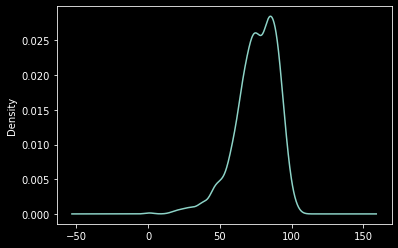

In [47]:
df.age_yrs.plot.density()

In [ ]:
q = s.query(Data, VaxData).join(VaxData)
q = q.filter(VaxData.vax_type == 'COVID19')
#.filter(Data.died == True)
#query = query.filter(Data.state == 'MS')

df = make_data_frame(q)
